# Machine Translation Project
## English to French
* RNN Recurrent Neural Networks (or more precisely LSTM/GRU) have been found to be very effective in solving complex sequence related problems given a large amount of data. They have real time applications in speech recognition, Natural Language Processing (NLP) problems, time series forecasting, etc. 

* Sequence to Sequence (often abbreviated to seq2seq) models are a special class of Recurrent Neural Network architectures typically used (but not restricted) to solve complex Language related problems like Machine Translation, Question Answering, creating Chat-bots, Text Summarization, etc.


## Introduction
In this notebook, we shall   build a deep neural network that functions as part of an end-to-end machine translation pipeline. Our completed pipeline will accept English text as input and return the French translation.

- **Preprocess** - We'll convert text to sequence of integers.
- **Models** Create models which accepts a sequence of integers as input and returns a probability distribution over possible translations. After learning about the basic types of neural networks that are often used for machine translation.
- **Accuracy of eeach model** We shall check and compare the accuracy of models 

### Dataset used
Download and unzip mar-eng.zip file from http://www.manythings.org/anki/

In [1]:
import collections
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
from string import digits
%matplotlib inline
import re

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Input
from tensorflow.keras.models import Model

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [10]:
from tensorflow.keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional
#from keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [11]:
import helper
import project_tests as tests

In [12]:
import os


def load_data(path):
    """
    Load dataset
    """
    input_file = os.path.join(path)
    with open(input_file, "r") as f:
        data = f.read()

    return data.split('\n')

## Dataset


In [67]:
lines = pd.read_table('fra.txt', names=['eng', 'french', 'code'])
lines = lines[1:10000]
lines.head(3)


,eng,french,code
1,Go.,Marche.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Go.,Bouge !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Hi.,Salut !,CC-BY 2.0 (France) Attribution: tatoeba.org #5...


In [68]:
len(lines)

9999

In [69]:
#Lowercase all characters
lines.eng = lines.eng.apply(lambda x: x.lower())
lines.french = lines.french.apply(lambda x: x.lower())

In [70]:
#REmove quotes
lines.eng=lines.eng.apply(lambda x: re.sub("'", '', x))
lines.french=lines.french.apply(lambda x: re.sub("'", '', x))

In [71]:
exclude = set(string.punctuation) # set of all special characters
#Remve all special characters
lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.mar=lines.french.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

C:\Users\user\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.


In [85]:
#Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines.eng=lines.eng.apply(lambda x: x.translate(remove_digits))
lines.french=lines.french.apply(lambda x: x.translate(remove_digits))


In [86]:
lines.tail(4)

,eng,french,code
9996,i bike to work,je vais au travail à bicyclette.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
9997,i bike to work,je me rends au travail en vélo.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
9998,i borrow money,jemprunte de largent.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
9999,i bought a hat,jai fait lacquisition dun chapeau.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...


In [87]:
# Remove extra spaces
lines.eng=lines.eng.apply(lambda x: x.strip())
lines.french=lines.french.apply(lambda x: x.strip())
lines.eng=lines.eng.apply(lambda x: re.sub(" +", " ", x))
lines.french=lines.french.apply(lambda x: re.sub(" +", " ", x))

In [88]:
lines.sample(10)

,eng,french,code
1719,destroy it,détruis-la.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
7060,i found these,jai trouvé ceux-ci.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3338,im patient,je suis patiente.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
6261,you look fat,tu as lair grosse.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
4319,are you hurt,êtes-vous blessées ?,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
3894,tom reacted,tom a réagi.,CC-BY 2.0 (France) Attribution: tatoeba.org #8...
6983,i didnt care,je nai pas fait attention.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
514,get lost,déguerpissez.,CC-BY 2.0 (France) Attribution: tatoeba.org #8...
1223,its late,il est tard.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
6793,he liked that,il la apprécié.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...



### Vocabulary
The complexity of the problem is determined by the complexity of the vocabulary.  A more complex vocabulary is a more complex problem.  Let's look at the complexity of the dataset we'll be working with.

### converting our data set to list for easy computations

In [89]:
english_sentences = lines['eng'].tolist()
french_sentences = lines['french'].tolist()

In [90]:
type(english_sentences)

list

In [91]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence])))
print('{} Unique English words.'.format(len(english_words_counter)))
print('10 MOST COMMON WORDS IN THE ENGLISH DATASET')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

111481 English words.
2016 Unique English words.
10 MOST COMMON WORDS IN THE ENGLISH DATASET
"i" "tom" "it" "you" "im" "a" "is" "me" "he" "go"

32926 French words.
5427 unique French words.
10 Most common words in the French dataset:
"je" "!" "?" "tom" "suis" "nous" "il" "cest" "est" "vous"


In [93]:
#french_sentences

# Preprocess
`Data preprocessing is a data mining technique which is used to transform the raw data in a useful and efficient format. Steps Involved in Data Preprocessing: 1. It involves handling of missing data, noisy data etc`

For this project, you won't use text data as input to your model. Instead, you'll convert the text into sequences of integers using the following preprocess methods:
1. Tokenize the words into ids
2. Add padding to make all the sequences the same length.

Time to start preprocessing the data...
### Tokenize (IMPLEMENTATION)
`To tokenize means to split the strings into individual words without blanks or tabs. In this same step, we will also convert each word in the string to lower case.`
For a neural network to predict on text data, it first has to be turned into data it can understand. Text data like "dog" is a sequence of ASCII character encodings.  Since a neural network is a series of multiplication and addition operations, the input data needs to be number(s).

We can turn each character into a number or each word into a number.  These are called character and word ids, respectively.  Character ids are used for character level models that generate text predictions for each character.  A word level model uses word ids that generate text predictions for each word.  Word level models tend to learn better, since they are lower in complexity, so we'll use those.

Turn each sentence into a sequence of words ids using Keras's [`Tokenizer`](https://keras.io/preprocessing/text/#tokenizer) function. Use this function to tokenize `english_sentences` and `french_sentences` in the cell below.

Running the cell will run `tokenize` on sample data and show output for debugging.

In [94]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    # TODO: Implement
    x_tk = Tokenizer(char_level = False)
    x_tk.fit_on_texts(x)
    return x_tk.texts_to_sequences(x), x_tk

# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


## Padding (IMPLEMENTATION)
When batching the sequence of word ids together, each sequence needs to be the same length.  Since sentences are dynamic in length, we can add padding to the end of the sequences to make them the same length.

Make sure all the English sequences have the same length and all the French sequences have the same length by adding padding to the **end** of each sequence using Keras's [`pad_sequences`](https://keras.io/preprocessing/sequence/#pad_sequences) function.

In [95]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen = length, padding = 'post')

tests.test_pad(pad)

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


# APPLYING THE PRE-PROCESSING TO OUR DATA

In [96]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 5
Max French sentence length: 10
English vocabulary size: 2016
French vocabulary size: 4393


## Models
In this section, you will experiment with various neural network architectures.
You will begin by training three relatively simple architectures.
- Model 1 is a simple RNN
- Model 2 is a Bidirectional RNN
- Model 3 is an optional Encoder-Decoder RNN

### Ids Back to Text
The neural network will be translating the input to words ids, which isn't the final form we want.  We want the French translation.  The function `logits_to_text` will bridge the gab between the logits from the neural network to the French translation.  You'll be using this function to better understand the output of the neural network.

In [99]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


### Model 1: RNN (IMPLEMENTATION)
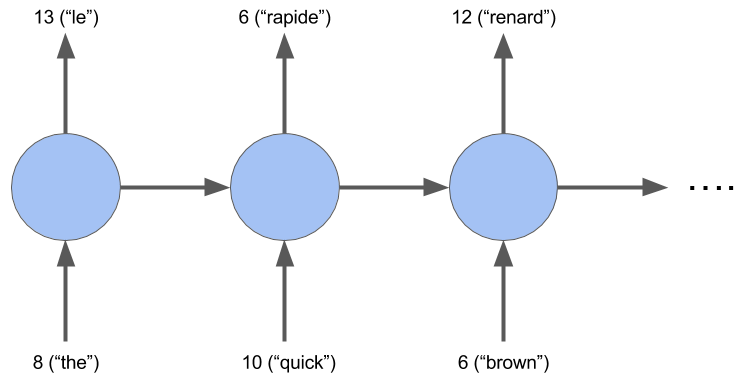
`A basic RNN model is a good baseline for sequence data. In this model, we'll build a RNN that translates English to French.`

In [100]:
preproc_english_sentences

array([[  10,    0,    0,    0,    0],
       [  10,    0,    0,    0,    0],
       [ 314,    0,    0,    0,    0],
       ...,
       [   1, 1454,   26,  102,    0],
       [   1, 2016,  306,    0,    0],
       [   1, 1102,    6,  641,    0]])

In [101]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [102]:
preproc_english_sentences = scaler.fit_transform(preproc_english_sentences)
#preproc_french_sentences = scaler.transform(preproc_french_sentences)

In [103]:
preproc_english_sentences

array([[-0.35418036, -0.67583288, -0.49071387, -0.16818209, -0.01570438],
       [-0.35418036, -0.67583288, -0.49071387, -0.16818209, -0.01570438],
       [ 1.17120342, -0.67583288, -0.49071387, -0.16818209, -0.01570438],
       ...,
       [-0.39933975,  2.89286864, -0.4173528 ,  0.43599387, -0.01570438],
       [-0.39933975,  4.27224295,  0.3726895 , -0.16818209, -0.01570438],
       [-0.39933975,  2.02891889, -0.4737844 ,  3.62864918, -0.01570438]])

In [104]:
def simple_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Build the layers
    learning_rate = 1e-3
    input_seq = Input(input_shape[1:])
    rnn = GRU(64, return_sequences = True)(input_seq)
    logits = TimeDistributed(Dense(french_vocab_size))(rnn)
    model = Model(input_seq, Activation('softmax')(logits))
    model.compile(loss = sparse_categorical_crossentropy, 
                 optimizer = Adam(learning_rate), 
                 metrics = ['accuracy'])
    
    return model
#tests.test_simple_model(simple_model)

In [105]:
# Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))


In [107]:

simple_rnn_model = simple_model(
    tmp_x.shape,
    preproc_french_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(french_tokenizer.word_index)+1)


simple_rnn_model = simple_rnn_model.fit(tmp_x, 
                                        preproc_french_sentences, 
                                        batch_size=1024, 
                                        epochs=10, 
                                        validation_split=0.2)



Train on 7999 samples, validate on 2000 samples
Epoch 1/10
7999/7999 [==============================] - 30s 4ms/sample - loss: 8.3756 - accuracy: 0.6352 - val_loss: 8.3546 - val_accuracy: 0.6389
Epoch 2/10
7999/7999 [==============================] - 28s 3ms/sample - loss: 8.3313 - accuracy: 0.6867 - val_loss: 8.2845 - val_accuracy: 0.6467
Epoch 3/10
7999/7999 [==============================] - 27s 3ms/sample - loss: 8.2256 - accuracy: 0.6885 - val_loss: 8.0931 - val_accuracy: 0.6468
Epoch 4/10
7999/7999 [==============================] - 27s 3ms/sample - loss: 7.9024 - accuracy: 0.6891 - val_loss: 7.4154 - val_accuracy: 0.6482
Epoch 5/10
7999/7999 [==============================] - 27s 3ms/sample - loss: 6.7784 - accuracy: 0.6896 - val_loss: 5.7232 - val_accuracy: 0.6488
Epoch 6/10
7999/7999 [==============================] - 28s 4ms/sample - loss: 5.0389 - accuracy: 0.6897 - val_loss: 4.2761 - val_accuracy: 0.6488
Epoch 7/10
7999/7999 [==============================] - 28s 4ms/sample

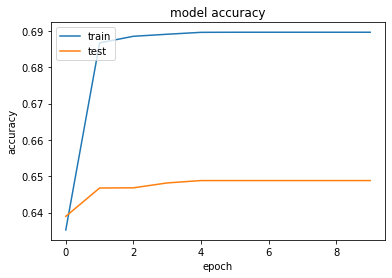

In [108]:
# summarize history for accuracy
plt.plot(simple_rnn_model.history['accuracy'])
plt.plot(simple_rnn_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model 2: Bidirectional RNNs (IMPLEMENTATION)
![RNN](images/bidirectional.png)
One restriction of a RNN is that it can't see the future input, only the past.  This is where bidirectional recurrent neural networks come in.  They are able to see the future data.

In [109]:
def bd_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a bidirectional RNN model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement
    learning_rate = 1e-3
    model = Sequential()
    model.add(Bidirectional(GRU(128, return_sequences = True, dropout = 0.1), 
                           input_shape = input_shape[1:]))
    model.add(TimeDistributed(Dense(french_vocab_size, activation = 'softmax')))
    model.compile(loss = sparse_categorical_crossentropy, 
                 optimizer = Adam(learning_rate), 
                 metrics = ['accuracy'])
    return model
#tests.test_bd_model(bd_model)


# TODO: Train and Print prediction(s)
tmp_x = pad(preproc_english_sentences, preproc_french_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

bidi_model = bd_model(
    tmp_x.shape,
    preproc_french_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(french_tokenizer.word_index)+1)


bidi_model = bidi_model.fit(tmp_x,
                            preproc_french_sentences,
                            batch_size=1024, epochs=20,
                            validation_split=0.2)

# Print prediction(s)
#print(logits_to_text(bidi_model.predict(tmp_x[:1])[0], french_tokenizer))

Train on 7999 samples, validate on 2000 samples
Epoch 1/20
7999/7999 [==============================] - 35s 4ms/sample - loss: 8.3571 - accuracy: 0.6602 - val_loss: 8.2941 - val_accuracy: 0.6467
Epoch 2/20
7999/7999 [==============================] - 29s 4ms/sample - loss: 8.1831 - accuracy: 0.6894 - val_loss: 7.9157 - val_accuracy: 0.6481
Epoch 3/20
7999/7999 [==============================] - 27s 3ms/sample - loss: 7.2755 - accuracy: 0.6896 - val_loss: 5.6175 - val_accuracy: 0.6488
Epoch 4/20
7999/7999 [==============================] - 30s 4ms/sample - loss: 3.8241 - accuracy: 0.6897 - val_loss: 2.8407 - val_accuracy: 0.6488
Epoch 5/20
7999/7999 [==============================] - 27s 3ms/sample - loss: 2.4100 - accuracy: 0.6897 - val_loss: 2.8928 - val_accuracy: 0.6488
Epoch 6/20
7999/7999 [==============================] - 28s 4ms/sample - loss: 2.3265 - accuracy: 0.6897 - val_loss: 2.7997 - val_accuracy: 0.6488
Epoch 7/20
7999/7999 [==============================] - 28s 4ms/sample

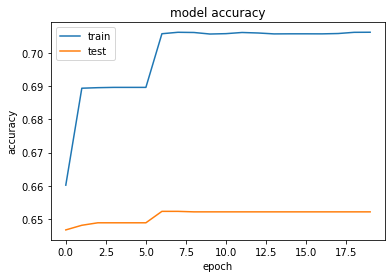

In [110]:
# summarize history for accuracy
plt.plot(bidi_model.history['accuracy'])
plt.plot(bidi_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model 4: Encoder-Decoder (OPTIONAL)
Time to look at encoder-decoder models.  This model is made up of an encoder and decoder. The encoder creates a matrix representation of the sentence.  The decoder takes this matrix as input and predicts the translation as output.

Create an encoder-decoder model in the cell below.

In [112]:
def encdec_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train an encoder-decoder model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # OPTIONAL: Implement
    learning_rate = 1e-3
    model = Sequential()
    model.add(GRU(128, input_shape = input_shape[1:], return_sequences = False))
    model.add(RepeatVector(output_sequence_length))
    model.add(GRU(128, return_sequences = True))
    model.add(TimeDistributed(Dense(french_vocab_size, activation = 'softmax')))
    
    model.compile(loss = sparse_categorical_crossentropy, 
                 optimizer = Adam(learning_rate), 
                 metrics = ['accuracy'])
    return model
#tests.test_encdec_model(encdec_model)

In [114]:

# OPTIONAL: Train and Print prediction(s)
tmp_x = pad(preproc_english_sentences)
tmp_x = tmp_x.reshape((-1, preproc_english_sentences.shape[1], 1))



encodeco_model = encdec_model(
    tmp_x.shape,
    preproc_french_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(french_tokenizer.word_index)+1)


encodeco_model = encodeco_model.fit(tmp_x,
                            preproc_french_sentences,
                            batch_size=1024, epochs=10,
                            validation_split=0.2)

Train on 7999 samples, validate on 2000 samples
Epoch 1/10
7999/7999 [==============================] - 30s 4ms/sample - loss: 8.3478 - accuracy: 0.6607 - val_loss: 8.2212 - val_accuracy: 0.6488
Epoch 2/10
7999/7999 [==============================] - 24s 3ms/sample - loss: 7.8736 - accuracy: 0.6897 - val_loss: 6.6914 - val_accuracy: 0.6488
Epoch 3/10
7999/7999 [==============================] - 24s 3ms/sample - loss: 5.2243 - accuracy: 0.6897 - val_loss: 3.8226 - val_accuracy: 0.6488
Epoch 4/10
7999/7999 [==============================] - 25s 3ms/sample - loss: 3.0518 - accuracy: 0.6897 - val_loss: 2.9418 - val_accuracy: 0.6488
Epoch 5/10
7999/7999 [==============================] - 24s 3ms/sample - loss: 2.5638 - accuracy: 0.6897 - val_loss: 2.9852 - val_accuracy: 0.6488
Epoch 6/10
7999/7999 [==============================] - 26s 3ms/sample - loss: 2.5544 - accuracy: 0.6897 - val_loss: 2.9508 - val_accuracy: 0.6488
Epoch 7/10
7999/7999 [==============================] - 25s 3ms/sample

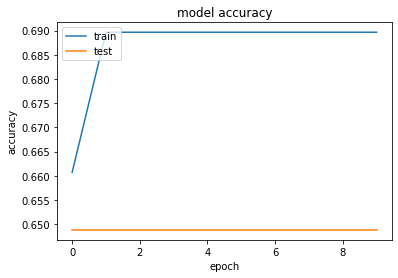

In [115]:
# summarize history for accuracy
plt.plot(encodeco_model.history['accuracy'])
plt.plot(encodeco_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model 4: Embedding (IMPLEMENTATION)
![RNN](images/embedding.png)
You've turned the words into ids, but there's a better representation of a word.  This is called word embeddings.  An embedding is a vector representation of the word that is close to similar words in n-dimensional space, where the n represents the size of the embedding vectors.

In this model, you'll create a RNN model using embedding.

In [120]:
from tensorflow.keras.models import Sequential
def embed_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a RNN model using word embedding on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement
    learning_rate = 1e-3
    rnn = GRU(64, return_sequences=True, activation="tanh")
    
    embedding = Embedding(french_vocab_size, 64, input_length=input_shape[1]) 
    logits = TimeDistributed(Dense(french_vocab_size, activation="softmax"))
    
    model = Sequential()
    #em can only be used in first layer --> Keras Documentation
    model.add(embedding)
    model.add(rnn)
    model.add(logits)
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    
    return model
#tests.test_embed_model(embed_model)


# TODO: Reshape the input
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2]))

# TODO: Train the neural network

In [122]:
# TODO: Train the neural network

embeded_model = embed_model(
    tmp_x.shape,
    preproc_french_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(french_tokenizer.word_index)+1)

embeded_model  = embeded_model.fit(tmp_x, 
                  preproc_french_sentences, 
                  batch_size=1024, epochs=10, 
                  validation_split=0.2)


# TODO: Print prediction(s)

Train on 7999 samples, validate on 2000 samples
Epoch 1/10
7999/7999 [==============================] - 23s 3ms/sample - loss: 8.3639 - accuracy: 0.5147 - val_loss: 8.3274 - val_accuracy: 0.6488
Epoch 2/10
7999/7999 [==============================] - 21s 3ms/sample - loss: 8.2693 - accuracy: 0.6897 - val_loss: 8.1676 - val_accuracy: 0.6488
Epoch 3/10
7999/7999 [==============================] - 21s 3ms/sample - loss: 7.9745 - accuracy: 0.6897 - val_loss: 7.6092 - val_accuracy: 0.6488
Epoch 4/10
7999/7999 [==============================] - 23s 3ms/sample - loss: 6.9741 - accuracy: 0.6897 - val_loss: 6.0855 - val_accuracy: 0.6488
Epoch 5/10
7999/7999 [==============================] - 27s 3ms/sample - loss: 5.3681 - accuracy: 0.6897 - val_loss: 4.7144 - val_accuracy: 0.6488
Epoch 6/10
7999/7999 [==============================] - 26s 3ms/sample - loss: 4.0975 - accuracy: 0.6897 - val_loss: 3.7316 - val_accuracy: 0.6488
Epoch 7/10
7999/7999 [==============================] - 24s 3ms/sample

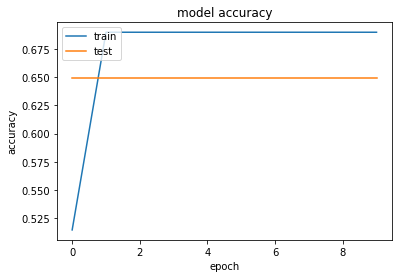

In [124]:
# summarize history for accuracy
plt.plot(embeded_model.history['accuracy'])
plt.plot(embeded_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Comparing the Three Architecture

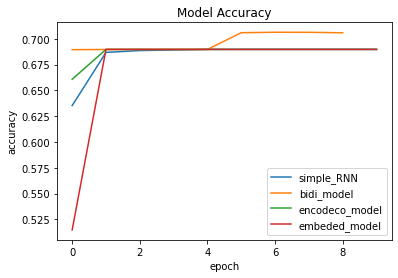

In [133]:
# summarize history for accuracy
plt.plot(simple_rnn_model.history['accuracy'])
plt.plot(bidi_model.history['accuracy'][1:10])
plt.plot(encodeco_model.history['accuracy'])
plt.plot(embeded_model.history['accuracy'])

plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['simple_RNN', 'bidi_model', 'encodeco_model', 'embeded_model'], loc='lower right')
plt.show()

# Table of Accuracy

In [159]:
hist_simple  = pd.DataFrame(simple_rnn_model.history) 
hist_encoder = pd.DataFrame(encodeco_model.history) 
hist_embeded = pd.DataFrame(embeded_model.history) 


hist_bidi = pd.DataFrame(bidi_model.history) 
hist_bidi = hist_bidi[1:10]
Accuracy_table['bidi_acc'] = hist_bidi['accuracy']

Accuracy_table.rename(columns ={'embeded':'embeded_acc'}, inplace =True)
Accuracy_table

,sim_accuracy,encodeco_acc,embeded_acc,bidi_acc
0,0.635204,0.660720,0.514727,NaN
1,0.686736,0.689661,0.689661,0.689411
2,0.688549,0.689661,0.689661,0.689574
3,0.689111,0.689661,0.689661,0.689661
4,0.689636,0.689661,0.689661,0.689661
5,0.689661,0.689661,0.689661,0.689661
6,0.689661,0.689661,0.689661,0.705851
7,0.689661,0.689661,0.689661,0.706288
8,0.689661,0.689661,0.689661,0.706226
9,0.689661,0.689661,0.689661,0.705763
